In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from image_extractor import DataSetup
data = DataSetup()

OS: Windows
0 :  overall_geometry
1 :  overall_rgb
2 :  overall_hsv
3 :  n1
4 :  structure
5 :  n2
6 :  moldered
7 :  color_grid
8 :  color_grid_2
9 :  glcm_grid
10 :  comp_hsv
11 :  glcm_2
12 :  lbp
13 :  haralick


In [2]:
data.concat(dataID=[0, 8, 9, 10, 12, 13])
model_dir = 'D:./TF_backup/mlp/' + data.model_name
checkpoint_dir = 'D:./TF_checkpoint/mlp/weight/'
print(model_dir)

input_shape = (data.length,)
batch_size = 8

model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
)

x_test size: (1680, 699)
x_train size: (6720, 699)
y_test size: (1680, 14)
y_train size: (6720, 14)
Model name = ' overall_geometry_color_grid_2_glcm_grid_comp_hsv_lbp_haralick.h5 '
D:./TF_backup/mlp/overall_geometry_color_grid_2_glcm_grid_comp_hsv_lbp_haralick.h5


In [16]:
normalizer = layers.Normalization()
normalizer.adapt(data.x_train)

# Define model
input_layer = layers.Input(shape=input_shape)
norm = normalizer(input_layer)
den1 = layers.Dense(1024, activation='tanh', kernel_initializer='HeNormal')(norm)
drop1 = layers.Dropout(0.2)(den1)
den2 = layers.Dense(1024, activation='tanh', kernel_initializer='HeNormal')(drop1)
drop2 = layers.Dropout(0.2)(den2)
den3 = layers.Dense(512, activation='tanh', kernel_initializer='HeNormal')(drop2)
drop3 = layers.Dropout(0.2)(den3)
# den4 = layers.Dense(512, activation='tanh', kernel_initializer='HeNormal')(drop3)
# drop4 = layers.Dropout(0.2)(den4)
den5 = layers.Dense(14, activation='sigmoid')(drop3)
model = keras.Model(input_layer, den5)

opt = tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.4,
    nesterov=True,
    name='SGD',
)

model.compile(
    optimizer=opt, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
    )

# model = keras.models.load_model(model_dir)

In [12]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 699)]             0         
                                                                 
 normalization_1 (Normalizat  (None, 699)              1399      
 ion)                                                            
                                                                 
 dense_12 (Dense)            (None, 1024)              716800    
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                           

In [19]:
epochs = 20
model.fit(data.x_train, data.y_train, batch_size=4, shuffle=True, epochs=epochs, callbacks=[model_checkpoint], validation_split=0.15)
model.save(model_dir)

Epoch 1/20
1428/1428 [==============================] - 8s 6ms/step - loss: 0.8723 - accuracy: 0.7034 - val_loss: 4.3750 - val_accuracy: 0.0397
Epoch 2/20
1428/1428 [==============================] - 8s 5ms/step - loss: 0.8430 - accuracy: 0.7150 - val_loss: 4.4576 - val_accuracy: 0.0387
Epoch 3/20
1428/1428 [==============================] - 8s 5ms/step - loss: 0.8125 - accuracy: 0.7211 - val_loss: 4.5246 - val_accuracy: 0.0407
Epoch 4/20
1428/1428 [==============================] - 8s 5ms/step - loss: 0.7856 - accuracy: 0.7302 - val_loss: 4.5950 - val_accuracy: 0.0407
Epoch 5/20
1428/1428 [==============================] - 8s 5ms/step - loss: 0.7625 - accuracy: 0.7391 - val_loss: 4.6580 - val_accuracy: 0.0407
Epoch 6/20
1428/1428 [==============================] - 8s 5ms/step - loss: 0.7405 - accuracy: 0.7461 - val_loss: 4.7208 - val_accuracy: 0.0417
Epoch 7/20
1428/1428 [==============================] - 8s 5ms/step - loss: 0.7127 - accuracy: 0.7560 - val_loss: 4.7789 - val_accuracy:

In [20]:
score = model.evaluate(data.x_test, data.y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

53/53 [==============================] - 0s 3ms/step - loss: 1.3877 - accuracy: 0.6417
Test loss: 1.387657642364502
Test accuracy: 0.6416666507720947


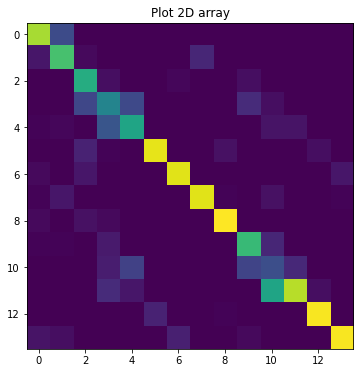

In [ ]:
i = 0
cmatrix = np.zeros((14,14), dtype=np.int16)
bat = int(len(data.x_test)/60)
for i in range(0, len(data.x_test),bat):
    result = model.predict_on_batch(data.x_test[i:i+bat])
    ans = data.y_test[i:i+bat]
    for j in range(bat):
        id1 = np.argmax(result[j])
        id2 = np.argmax(ans[j])
        cmatrix[id1, id2] = cmatrix[id1][id2] + 1

cmatrix = np.absolute(cmatrix)
# print(repr(cmatrix))

fig = plt.figure(figsize=(6,6))
plt.imshow(cmatrix)
plt.title("Plot 2D array")
plt.show()

In [ ]:
classes_name = ['Agglutinated', 'Brittle', 'Compartmentalized_Brown', 'Compartmentalized_PartiallyPurple', 'Compartmentalized_Purple', 'Compartmentalized_Slaty', 'Compartmentalized_White', 'Flattened', 'Moldered', 'Plated_Brown', 'Plated_PartiallyPurple', 'Plated_Purple', 'Plated_Slaty', 'Plated_White']
acc = []
for i in range(14):
    acc.append(np.round(cmatrix[i][i]/120,3))
    print(classes_name[i] + ': \t \t' + str(acc[i]))
print(np.mean(acc))

Agglutinated: 	 	0.817
Brittle: 	 	0.667
Compartmentalized_Brown: 	 	0.583
Compartmentalized_PartiallyPurple: 	 	0.425
Compartmentalized_Purple: 	 	0.55
Compartmentalized_Slaty: 	 	0.908
Compartmentalized_White: 	 	0.9
Flattened: 	 	0.9
Moldered: 	 	0.942
Plated_Brown: 	 	0.633
Plated_PartiallyPurple: 	 	0.225
Plated_Purple: 	 	0.842
Plated_Slaty: 	 	0.933
Plated_White: 	 	0.933
0.7327142857142857
